In [1]:
import json
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

from sklearn.svm import SVC
import joblib

import gensim.downloader as api

from sklearn.preprocessing import OneHotEncoder

/users/eleves-b/2021/timothee.vincon/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

path_to_training = Path("../data/training")
path_to_test = Path("../data/test")

In [3]:
test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

In [4]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
y_training = []
with open("../data/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = [] 
X_training_edges = []
X_training_speaker = []

In [6]:
edge_types = ['Continuation', 'Explanation', 'Elaboration', 'Acknowledgement', 'Comment', 'Result', 'Question-answer_pair', 'Contrast', 'Clarification_question', 'Background', 'Narration', 'Alternation', 'Conditional', 'Q-Elab', 'Correction', 'Parallel']
speakers = ['PM', 'ME', 'UI', 'ID']

encoder_edge = OneHotEncoder(handle_unknown='ignore')
encoder_edge.fit(np.array(edge_types).reshape(-1, 1))

encoder_speaker = OneHotEncoder(handle_unknown='ignore')
encoder_speaker.fit(np.array(speakers).reshape(-1, 1))

print(encoder_edge.transform(np.array(['Explanation']).reshape(-1,1)).toarray().squeeze())
print(encoder_speaker.transform(np.array(['ME']).reshape(-1,1)).toarray().squeeze())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0.]


In [7]:
for transcription_id in training_set:
    
    file_path = "../data/training/" + transcription_id + '.txt'

    with open(file_path, 'r') as file:

        edge_type_transcriptionId = []

        for line in file:

            # Split the line in words
            words = line.split()

            # If the line is not empty
            if words:
                edge_type_transcriptionId.append(words[1])    # Type of the edge
                if words[1] not in edge_types:
                    edge_types.append(words[1])
            else:
                print("line is empty")
    
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)

    X_training_text_current = []

    c = 0
    for utterance in transcription:
        speaker = encoder_speaker.transform(np.array([utterance["speaker"]]).reshape(-1,1)).toarray().squeeze()
        
        X_training_speaker.append(speaker)


        if(c == 0):
            X_training.append(utterance["text"])
            X_training_edges.append(np.array([0.0]*len(edge_types)))
            X_training_text_current.append(utterance["text"])
        else:
            X_training.append(utterance["text"])
            edge = encoder_edge.transform(np.array([edge_type_transcriptionId[c-1]]).reshape(-1,1)).toarray().squeeze()
            X_training_edges.append(edge)
            X_training_text_current.append(utterance["text"])
        c+=1

    y_training += training_labels[transcription_id]

In [8]:
print("start encoding") 

X_training = bert.encode(X_training, show_progress_bar=True)

start encoding


Batches: 100%|██████████| 2270/2270 [00:10<00:00, 206.39it/s]


In [9]:
print(X_training_edges[0])

print(X_training_speaker[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0.]


In [10]:
X_training_edges = np.array(X_training_edges)
X_training_speaker = np.array(X_training_speaker)

print(X_training.shape)
print(X_training_edges.shape)
print(X_training_speaker.shape)

(72623, 384)
(72623, 16)
(72623, 4)


In [11]:
X_training_final = [np.concatenate((x, y, z)) for x, y,z in zip(X_training, X_training_speaker, X_training_edges)]
print("final premier element ", X_training_final[0].shape)
print("encoding training dataset finished")

final premier element  (404,)
encoding training dataset finished


In [12]:
print(np.min(X_training_final[0]))
print(np.max(X_training_final[0]))

maxi = 0
for i in range(len(X_training_final[0])):
    if maxi < X_training_final[0][i] and X_training_final[0][i] < 1:
        maxi = X_training_final[0][i]
print(maxi)

-0.14650167524814606
1.0
0.22034260630607605


In [13]:
print(np.array(X_training_final).shape)
print(np.array(y_training).shape)

(72623, 404)
(72623,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_training), y_training, test_size=0.2, random_state=42)

print("split done")

split done


In [17]:
print(X_training.shape)

(72623, 384)


In [18]:
# create a svm classifier

clf = SVC(kernel='rbf', verbose=True, C=1, class_weight='balanced', cache_size=4000, probability=True)

# Train the model using the training sets

clf.fit(X_train, y_train)

print("fit done")

[LibSVM]..............................*........*.*
optimization finished, #iter = 38434
obj = -15113.568966, rho = -0.058639
nSV = 22998, nBSV = 14759
Total nSV = 22998
.............................*........*
optimization finished, #iter = 37874
obj = -15065.250857, rho = -0.052288
nSV = 22929, nBSV = 14736
Total nSV = 22929
.............................*.........*
optimization finished, #iter = 38076
obj = -15057.534519, rho = -0.047689
nSV = 22959, nBSV = 14756
Total nSV = 22959
.............................*........*
optimization finished, #iter = 37753
obj = -15024.107021, rho = -0.108421
nSV = 22849, nBSV = 14649
Total nSV = 22849
.............................*........*
optimization finished, #iter = 37728
obj = -15037.401750, rho = -0.058067
nSV = 22872, nBSV = 14738
Total nSV = 22872
.....................................
*..........*
optimization finished, #iter = 47659
obj = -18924.980801, rho = 0.059207
nSV = 28344, nBSV = 18949
Total nSV = 28344
fit done


In [48]:
y_pred = clf.predict(X_test)

print("predict done")

# compute F1 score

print(f1_score(y_test, y_pred))

predict done
0.5859667916443492


In [49]:
y_pred_proba = clf.predict_proba(X_test)

In [50]:
threshold = 0.73

for i in range(len(y_pred_proba)):
    if y_pred_proba[i][0] > threshold:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

print(f1_score(y_test, y_pred))

0.5981059485054749


In [51]:
# print TP, FP, TN, FN

print("TP : ", np.sum(np.logical_and(y_test, y_pred)))
print("FP : ", np.sum(np.logical_and(np.logical_not(y_test), y_pred)))
print("TN : ", np.sum(np.logical_and(np.logical_not(y_test), np.logical_not(y_pred))))
print("FN : ", np.sum(np.logical_and(y_test, np.logical_not(y_pred))))

TP :  2021
FP :  2099
TN :  9788
FN :  617


In [52]:
joblib.dump(clf, 'SVM.joblib')

['SVM.joblib']

In [57]:
clf = joblib.load('SVM.joblib')

In [58]:
clf.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 4000,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': True}

In [59]:
test_labels = {}
for transcription_id in test_set:

    X_test = [] 
    X_test_edges = []
    X_test_speaker = []

    X_test_edges.append(np.array([0.0]*len(edge_types)))
    
    file_path = "../data/test/" + transcription_id + '.txt'

    with open(file_path, 'r') as file:

        edge_type_transcriptionId = []
        c_line = 0

        for line in file:

            # Split the line in words
            words = line.split()

            # If the line is not empty
            if words:
                edge_type_transcriptionId.append(words[1])    # Type of the edge
                if words[1] not in edge_types:
                    edge_types.append(words[1])
            else:
                print("WORDSSSSSSSSSSSSSSSSSSSSSSS")

            c_line += 1
    

    with open(path_to_test / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)

    c = 0
    for utterance in transcription:
        speaker = encoder_speaker.transform(np.array([utterance["speaker"]]).reshape(-1,1)).toarray().squeeze()
        
        X_test_speaker.append(speaker)


        if(c == 0):
            X_test.append(utterance["text"])
        else:
            X_test.append(utterance["text"])
            edge = encoder_edge.transform(np.array([edge_type_transcriptionId[c-1]]).reshape(-1,1)).toarray().squeeze()
            X_test_edges.append(edge)
        c+=1
    
    X_test = bert.encode(X_test, show_progress_bar=True)

    X_test_edges = np.array(X_test_edges)
    X_test_speaker = np.array(X_test_speaker)

    X_test_final = [np.concatenate((x, y, z)) for x, y,z in zip(X_test_speaker, X_test, X_test_edges)]

    y_test = np.array([0]*len(X_test))
    y_test_proba = clf.predict_proba(X_test)
    # replace y_test by 0 or 1
    for i in range(len(y_test_proba)):
        if y_test_proba[i][0] > threshold:
            y_test[i] = 0
        else:
            y_test[i] = 1
    test_labels[transcription_id] = y_test.tolist()

with open("../submissions/test_labels_SVM_enhanced.json", "w") as file:
    json.dump(test_labels, file, indent=4)

Batches: 100%|██████████| 46/46 [00:00<00:00, 195.93it/s]


In [69]:
n_hunits=512


model = nn.Sequential(
    nn.Linear(404, n_hunits),
    nn.ReLU(),
    nn.Linear(n_hunits, n_hunits),
    nn.ReLU(),
    nn.Linear(n_hunits, 2),
    nn.Softmax(dim=1)
)

In [70]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=404, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move training data to GPU

X_train = torch.tensor(np.array(X_train)).float().to(device)
y_train = torch.tensor(np.array(y_train)).long().to(device)

X_test = torch.tensor(np.array(X_test)).float().to(device)
y_test = torch.tensor(np.array(y_test)).long().to(device)

epoch :  0 / 5000 loss :  0.4190415 train f1 :  0.690002140869193 test f1 :  0.48891814790432303 lr :  0.4
epoch :  500 / 5000 loss :  0.43759286 train f1 :  0.6648527669285119 test f1 :  0.2410993129294191 lr :  0.36000000000000004
epoch :  1000 / 5000 loss :  0.42833903 train f1 :  0.6843082636954503 test f1 :  0.3556531284302964 lr :  0.32400000000000007
epoch :  1500 / 5000 loss :  0.42523012 train f1 :  0.6947417620939472 test f1 :  0.37220576353353085 lr :  0.2916000000000001
epoch :  2000 / 5000 loss :  0.42226636 train f1 :  0.7046203067657851 test f1 :  0.37689645994144266 lr :  0.26244000000000006
epoch :  2500 / 5000 loss :  0.41953966 train f1 :  0.714103472714387 test f1 :  0.38102766798418974 lr :  0.23619600000000007
epoch :  3000 / 5000 loss :  0.41687387 train f1 :  0.7218401707374911 test f1 :  0.3850183342063908 lr :  0.21257640000000008
epoch :  3500 / 5000 loss :  0.4140669 train f1 :  0.7296665553594428 test f1 :  0.39346811819595645 lr :  0.1913187600000001
epoch

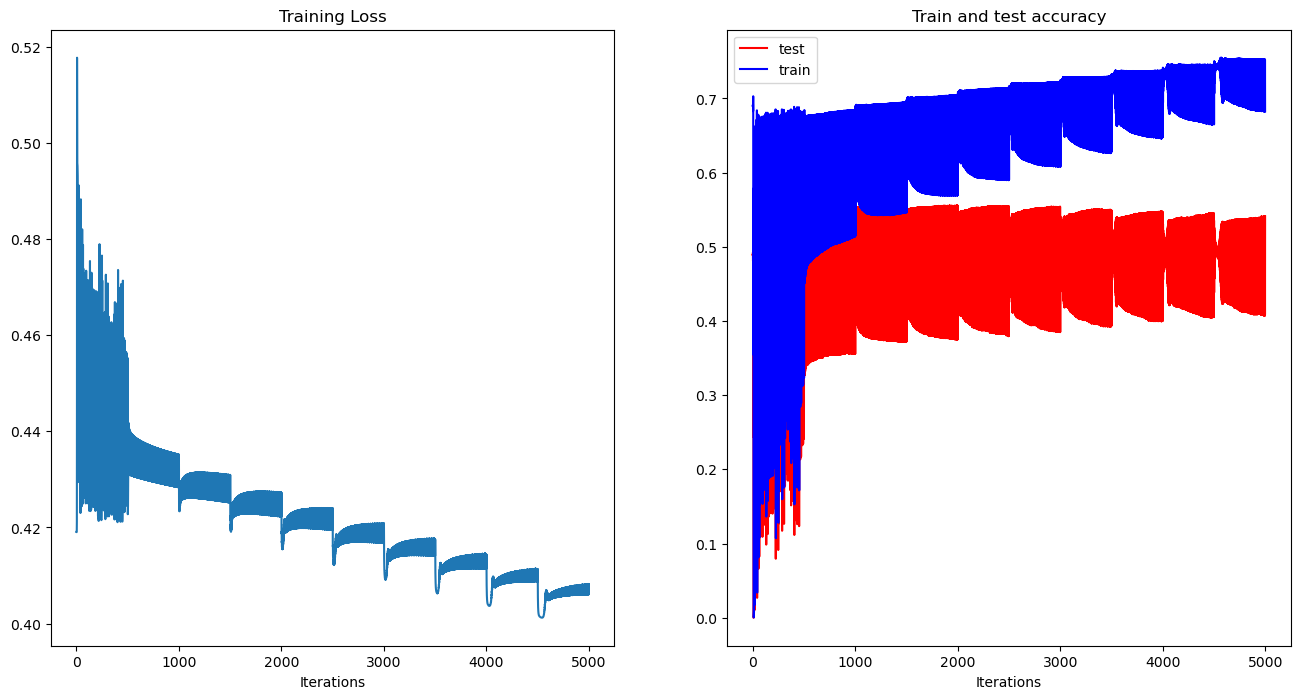

In [76]:

model.to(device) #if you have CUDA, this will make computation faster

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4) #actually SGD is just GD in this case

#init performance measures
losses = []
tr_acc = []
test_acc = []

nb_epochs=5000

for epoch in range(nb_epochs):
    output=model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    #update loss and accuracy
    losses.append(loss.data.cpu().numpy())
    output_te=model(X_test)
    tr_acc.append(f1_score(y_train.cpu(), torch.max(output.cpu(), 1)[1]))
    test_acc.append(f1_score(y_test.cpu(), torch.max(output_te.cpu(), 1)[1]))
    if epoch % 500 == 0:
        print('epoch : ', epoch, '/', nb_epochs, 'loss : ', loss.data.cpu().numpy(), 'train f1 : ', tr_acc[-1], 'test f1 : ', test_acc[-1], 'lr : ', optimizer.param_groups[0]['lr'])
        optimizer.param_groups[0]['lr'] *= 0.9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(tr_acc, c='b', label='train')
ax2.set_title("Train and test F1 score")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()